In [9]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

from typing import List, Dict
from PIL import Image
from scipy.signal import find_peaks
from sklearn.linear_model import LinearRegression
from skimage.filters import threshold_otsu

plt.style.use("seaborn-v0_8-darkgrid")

(np.float64(-0.5), np.float64(1809.5), np.float64(795.5), np.float64(-0.5))

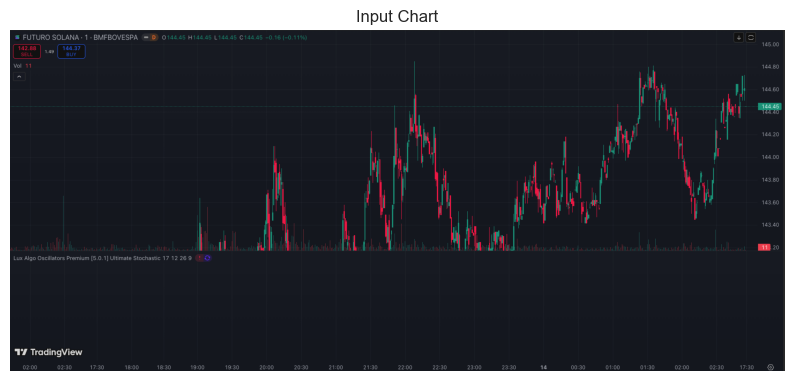

In [10]:
IMAGE_PATH = "../data/sample_chart.png"
assert os.path.exists(IMAGE_PATH), "Chart image not found"

img = cv2.imread(IMAGE_PATH)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 5))
plt.imshow(img_rgb)
plt.title("Input Chart")
plt.axis("off")

(np.float64(-0.5), np.float64(1809.5), np.float64(795.5), np.float64(-0.5))

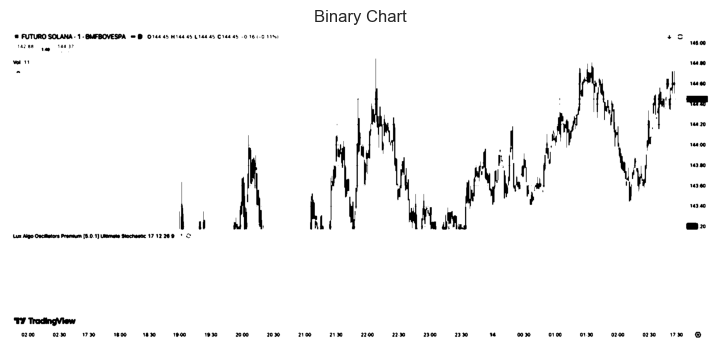

In [11]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

thresh = threshold_otsu(gray)
binary = gray < thresh

plt.figure(figsize=(10, 4))
plt.imshow(binary, cmap="gray")
plt.title("Binary Chart")
plt.axis("off")

In [12]:
height, width = binary.shape
columns = []

for x in range(width):
    ys = np.where(binary[:, x])[0]
    if len(ys) > 0:
        columns.append((x, ys.min(), ys.max()))

In [13]:
candles = []
current = [columns[0]]

for col in columns[1:]:
    if col[0] - current[-1][0] <= 2:
        current.append(col)
    else:
        candles.append(current)
        current = [col]

candles.append(current)

In [14]:
ohlc = []

for candle in candles:
    xs = [c[0] for c in candle]
    tops = [c[1] for c in candle]
    bottoms = [c[2] for c in candle]

    open_price = tops[0]
    close_price = tops[-1]
    high_price = min(tops)
    low_price = max(bottoms)

    ohlc.append([open_price, high_price, low_price, close_price])

ohlc = pd.DataFrame(
    ohlc, columns=["open", "high", "low", "close"]
)

In [15]:
ohlc = (height - ohlc)
ohlc = (ohlc - ohlc.min()) / (ohlc.max() - ohlc.min())

ohlc.head()

,open,high,low,close
0,NaN,NaN,NaN,NaN


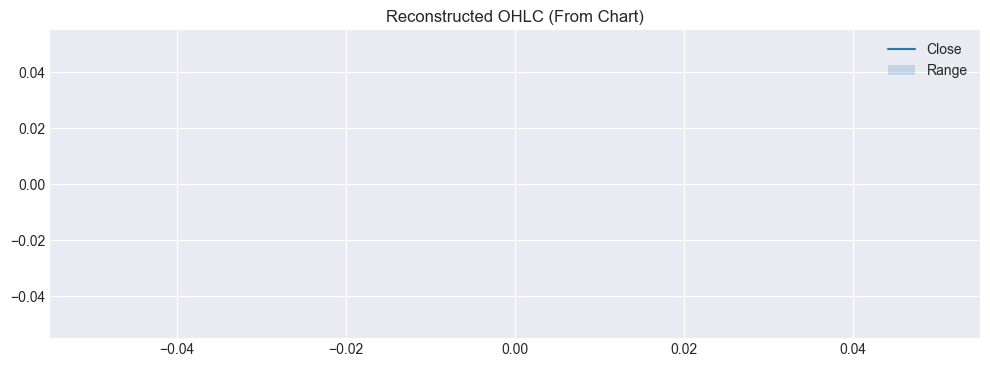

In [16]:
plt.figure(figsize=(12, 4))
plt.plot(ohlc["close"], label="Close")
plt.fill_between(
    ohlc.index,
    ohlc["low"],
    ohlc["high"],
    alpha=0.2,
    label="Range",
)
plt.legend()
plt.title("Reconstructed OHLC (From Chart)")
plt.show()

In [17]:
def ema(series: pd.Series, span: int) -> pd.Series:
    return series.ewm(span=span, adjust=False).mean()

def rsi(series: pd.Series, period: int = 14) -> pd.Series:
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)

    avg_gain = gain.rolling(period).mean()
    avg_loss = loss.rolling(period).mean()

    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

In [18]:
ohlc["ema_fast"] = ema(ohlc["close"], 12)
ohlc["ema_slow"] = ema(ohlc["close"], 26)
ohlc["rsi"] = rsi(ohlc["close"])

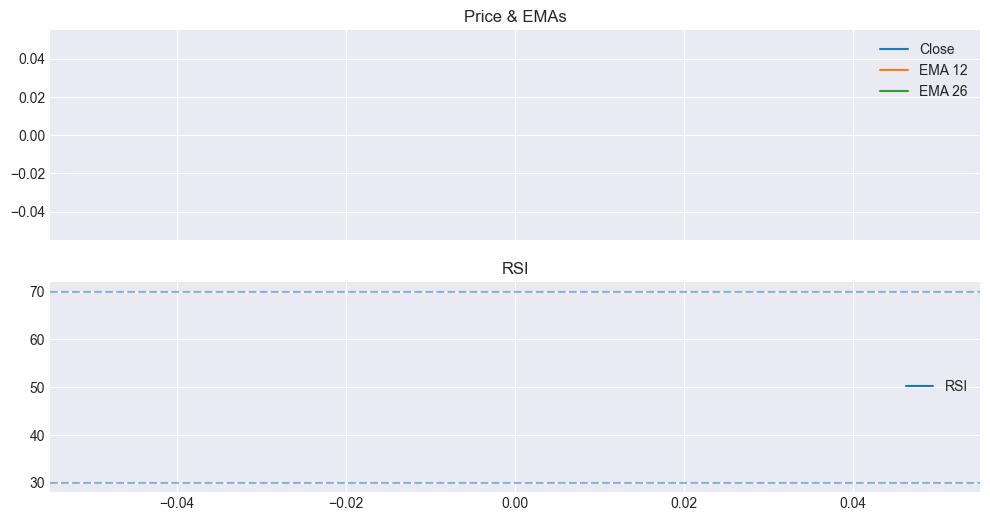

In [19]:
fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

axes[0].plot(ohlc["close"], label="Close")
axes[0].plot(ohlc["ema_fast"], label="EMA 12")
axes[0].plot(ohlc["ema_slow"], label="EMA 26")
axes[0].legend()
axes[0].set_title("Price & EMAs")

axes[1].plot(ohlc["rsi"], label="RSI")
axes[1].axhline(70, linestyle="--", alpha=0.5)
axes[1].axhline(30, linestyle="--", alpha=0.5)
axes[1].legend()
axes[1].set_title("RSI")

plt.show()

In [20]:
signals = []

for i in range(1, len(ohlc)):
    if (
        ohlc["ema_fast"].iloc[i] > ohlc["ema_slow"].iloc[i]
        and ohlc["ema_fast"].iloc[i - 1] <= ohlc["ema_slow"].iloc[i - 1]
        and ohlc["rsi"].iloc[i] < 70
    ):
        signals.append("BUY")

    elif (
        ohlc["ema_fast"].iloc[i] < ohlc["ema_slow"].iloc[i]
        and ohlc["ema_fast"].iloc[i - 1] >= ohlc["ema_slow"].iloc[i - 1]
        and ohlc["rsi"].iloc[i] > 30
    ):
        signals.append("SELL")

    else:
        signals.append("HOLD")

signals.insert(0, "HOLD")
ohlc["signal"] = signals

In [21]:
ohlc["signal"].value_counts()

signal
HOLD    1
Name: count, dtype: int64

In [22]:
print(" --- VISION-BASED STRATEGY ENGINE")
print("=" * 55)

print(f"Total Candles     : {len(ohlc)}")
print(f"BUY Signals       : {(ohlc['signal'] == 'BUY').sum()}")
print(f"SELL Signals      : {(ohlc['signal'] == 'SELL').sum()}")

print("\nLast 10 Signals")
display(ohlc.tail(10))

 --- VISION-BASED STRATEGY ENGINE
Total Candles     : 1
BUY Signals       : 0
SELL Signals      : 0

Last 10 Signals


,open,high,low,close,ema_fast,ema_slow,rsi,signal
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HOLD
